### 1. Import Libraries and Load Data

In [19]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [20]:
file_path = 'https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/EasyVisa%20(1).csv'

### 2. EDA-Based Data Quality Assessment

In [21]:
def load_check_data_quality(file_path):
    """
    Loads dataset, performs basic data quality check
    
    Steps:
    1. Load CSV file.
    2. check missing value.
    3. check for duplicate.
    4. Check skewness for variables identified in EDA as right-skewed.
  
    """

    # === 1. Load dataset ===
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully: {file_path}")
        print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

    # === 1. Missing Values ===
    print("\n=== MISSING VALUE PERCENTAGES ===")
    missing = df.isnull().mean() * 100
    print(missing[missing > 0].sort_values(ascending=False))

    # 2. Check for duplicates
    print("\n2. Duplicate Rows:")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")
    if duplicates > 0:
        print(f"Percentage of duplicates: {(duplicates/len(df))*100:.2f}%")

    # 3. Check skewness for variables identified in EDA as right-skewed
    print("\n3. Skewness Analysis (EDA identified right-skewed variables):")
    skewed_vars = ['no_of_employees', 'yr_of_estab', 'prevailing_wage ']
    for var in skewed_vars:
         if var in df.columns:
            skewness = skew(df[var])
         print(f"{var}: skewness = {skewness:.3f} "
         f"({'strongly skewed' if abs(skewness) > 0.7 else 'moderately skewed' if abs(skewness) > 0.3 else 'approximately normal'})")

   

    return df


In [22]:
df = load_check_data_quality(file_path)

Dataset loaded successfully: https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/EasyVisa%20(1).csv
Shape: 25480 rows × 12 columns


=== MISSING VALUE PERCENTAGES ===
Series([], dtype: float64)

2. Duplicate Rows:
Number of duplicate rows: 0

3. Skewness Analysis (EDA identified right-skewed variables):
no_of_employees: skewness = 12.265 (strongly skewed)
yr_of_estab: skewness = -2.037 (strongly skewed)
prevailing_wage : skewness = -2.037 (strongly skewed)


### 3. Data Cleaning

In [23]:
def clean_employee_data(df):
    """
    Data Cleaning
    ---------------------
    Handles duplicates, missing values, inconsistencies, and outliers.
    """
    # Remove duplicates
    df = df.drop_duplicates()

    # Handle missing values
    print("\n=== HANDLING MISSING VALUES ===")

    # lets iomport the imputer library
    from sklearn.impute import SimpleImputer
    
        # Prints and returns all categorical columns in the DataFrame.
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    print(f"Numerical Features:\n{numerical_features}")

    # Prints and returns all categorical columns in the DataFrame.
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    print(f"Categorical Features:\n{categorical_features}")

    # Lets create an instance of the imputer class using "median" as strategy for imputation
    num_imputer = SimpleImputer(strategy="median")

    # Lets create an instance of the imputer class using "most_frequent" as strategy for imputation
    cat_imputer = SimpleImputer(strategy="most_frequent")

        # Lets apply the defined instances above
    df[numerical_features] = num_imputer.fit_transform(df[numerical_features])
    df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])
    
    # Correct inconsistencies
    text_cols = df.select_dtypes(include=['object']).columns
    for col in text_cols:
        df[col] = df[col].str.strip().str.title()

    # Handle outliers (IQR method)
    # Outlier treatment based on EDA recommendations
    print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")
    print("EDA recommended IQR-capping for  to preserve data points")

    # Define numerical columns (excluding target)
    numerical_cols =  ['no_of_employees', 'yr_of_estab', 'prevailing_wage']
    if 'case_status' in numerical_cols:
        numerical_cols.remove('case_status')

    print(f"Treating outliers in {len(numerical_cols)} numerical features...")

    # Apply IQR-capping method
    outliers_capped = 0
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers before capping
        outliers_before = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        
        if outliers_before > 0:
            # Cap outliers
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
            outliers_capped += outliers_before
            print(f"✓ {col}: Capped {outliers_before} outliers")

    print(f"\nTotal outliers capped: {outliers_capped}")
    print(f"Dataset shape after outlier treatment: {df.shape}")

    print("Data cleaning complete.")

    return df


In [24]:
df = clean_employee_data(df)


=== HANDLING MISSING VALUES ===
Numerical Features:
['no_of_employees', 'yr_of_estab', 'prevailing_wage']
Categorical Features:
['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']
=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===
EDA recommended IQR-capping for  to preserve data points
Treating outliers in 3 numerical features...
✓ no_of_employees: Capped 1556 outliers
✓ yr_of_estab: Capped 3260 outliers
✓ prevailing_wage: Capped 427 outliers

Total outliers capped: 5243
Dataset shape after outlier treatment: (25480, 12)
Data cleaning complete.


### 4. Encoding(like label encoding and one-hot encoding)

In [25]:
def transform_employee_data(df):
    """
    Step 2: Transformation (Encoding)
    ---------------------------------
    Converts categorical variables into numeric using Label & One-Hot encoding.
    """
   # Label Encoding (binary columns)
    label_map = {
        'has_job_experience': {'Y': 1, 'N': 0},
        'requires_job_training': {'Y': 1, 'N': 0},
        'full_time_position': {'Y': 1, 'N': 0},
        'case_status': {'Certified': 1, 'Denied': 0}
    }

    for col, mapping in label_map.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # One-hot Encoding (multi-category columns)
    onehot_cols = [
        'continent',
        'education_of_employee',
        'region_of_employment',
        'unit_of_wage'
    ]

    df = pd.get_dummies(df, columns=onehot_cols, drop_first=False, dtype=int)

    print("Transformation (encoding) complete.")
    return df


In [26]:
df_processed = transform_employee_data(df)
print(df_processed.head())

Transformation (encoding) complete.
  case_id  has_job_experience  requires_job_training  no_of_employees  \
0  Ezyv01                   0                      0           7227.0   
1  Ezyv02                   1                      0           2412.0   
2  Ezyv03                   0                      1           7227.0   
3  Ezyv04                   0                      0             98.0   
4  Ezyv05                   1                      0           1082.0   

   yr_of_estab  prevailing_wage  full_time_position  case_status  \
0       2007.0         592.2029                   1            0   
1       2002.0       83425.6500                   1            1   
2       2008.0      122996.8600                   1            0   
3       1932.5       83434.0300                   1            0   
4       2005.0      149907.3900                   1            1   

   continent_Africa  continent_Asia  ...  education_of_employee_Master'S  \
0                 0               1  ...

### 5. Log-Transform Skewed Variables (EDA Recommendation)

In [27]:
import numpy as np
from scipy.stats import skew

def normalize_employee_data(df_processed):
    """
    Step: Normalization
    ---------------------
    Safely applies log transformation to skewed numeric features.
    Handles zeros, negatives, and NaNs automatically.
    """
    print("=== LOG-TRANSFORMING SKEWED VARIABLES ===")
    print("EDA identified these variables as right-skewed and recommended log transformation:")

    # Variables identified as skewed from EDA
    skewed_vars = ['no_of_employees', 'yr_of_estab', 'prevailing_wage']

    for var in skewed_vars:
        if var in df_processed.columns:
            # Ensure numeric
            if not np.issubdtype(df_processed[var].dtype, np.number):
                print(f"Skipping {var}: non-numeric column.")
                continue

            # Handle NaN safely
            df[var] = df_processed[var].fillna(0)

            # Check for zeros/negatives
            min_val = df_processed[var].min()
            if min_val <= 0:
                shift = abs(min_val) + 1
                df_processed[f'{var}_log'] = np.log1p(df_processed[var] + shift)
                print(f"✓ {var}: Shifted by {shift:.2f} and applied log1p (min={min_val:.3f})")
            else:
                df_processed[f'{var}_log'] = np.log1p(df_processed[var])
                print(f"✓ {var}: Applied log1p transformation (all positive values)")

            # Compute skewness safely
            try:
                original_skew = skew(df_processed[var], nan_policy='omit')
                transformed_skew = skew(df_processed[f'{var}_log'], nan_policy='omit')
                print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")
            except Exception as e:
                print(f"Skewness computation failed for {var}: {e}")

    print(f"\nDataset shape after log transformation: {df_processed.shape}")
    print("New log-transformed columns:", [col for col in df_processed.columns if '_log' in col])
    print("Normalization (log transform) complete.\n")

    return df_processed


In [28]:
df_processed = normalize_employee_data(df_processed)

=== LOG-TRANSFORMING SKEWED VARIABLES ===
EDA identified these variables as right-skewed and recommended log transformation:
✓ no_of_employees: Shifted by 27.00 and applied log1p (min=-26.000)
  Original skewness: 0.959 → Transformed skewness: -1.145
✓ yr_of_estab: Applied log1p transformation (all positive values)
  Original skewness: -1.111 → Transformed skewness: -1.124
✓ prevailing_wage: Applied log1p transformation (all positive values)
  Original skewness: 0.547 → Transformed skewness: -2.136

Dataset shape after log transformation: (25480, 30)
New log-transformed columns: ['no_of_employees_log', 'yr_of_estab_log', 'prevailing_wage_log']
Normalization (log transform) complete.



### 6. Feature Engineering

In [29]:
def enhance_employee_data(df_processed):
    """
    Step 4: Feature Engineering
    ---------------------------
    Creates new, meaningful derived features.
    """
    df_processed['wage_per_employee'] = df_processed['prevailing_wage'] / (df_processed['no_of_employees'] + 1)
    df_processed['firm_age'] = 2025 - df_processed['yr_of_estab']
    df['experience_training'] = df['has_job_experience'] * df_processed['requires_job_training']

    print("Feature engineering complete.")
    print(f"\nDataset shape after feature engineering: {df_processed.shape}")
    print(f"New engineered features: {[col for col in df_processed.columns if col not in df.columns]}")

    return df_processed


In [30]:
df_processed = enhance_employee_data(df_processed)
#df.columns

Feature engineering complete.

Dataset shape after feature engineering: (25480, 32)
New engineered features: ['continent_Africa', 'continent_Asia', 'continent_Europe', 'continent_North America', 'continent_Oceania', 'continent_South America', "education_of_employee_Bachelor'S", 'education_of_employee_Doctorate', 'education_of_employee_High School', "education_of_employee_Master'S", 'region_of_employment_Island', 'region_of_employment_Midwest', 'region_of_employment_Northeast', 'region_of_employment_South', 'region_of_employment_West', 'unit_of_wage_Hour', 'unit_of_wage_Month', 'unit_of_wage_Week', 'unit_of_wage_Year', 'no_of_employees_log', 'yr_of_estab_log', 'prevailing_wage_log', 'wage_per_employee', 'firm_age']


### 7. Feature Selection

In [31]:
from sklearn.feature_selection import chi2
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

def feature_selection_by_significance(df, target='case_status', p_threshold=0.05):
    """
    Automatically selects statistically significant features for case_status classification.
    Handles mixed data, NaNs, and encoding artifacts safely.
    """
    print("=== FEATURE SELECTION BASED ON STATISTICAL SIGNIFICANCE ===")

    # Drop rows with missing target
    df = df_processed.dropna(subset=[target])

    # Separate X and y
    X = df_processed.drop(columns=[target])
    y = df_processed[target]

    # Convert boolean or object columns to numeric if possible
    for col in X.columns:
        if X[col].dtype == 'bool':
            X[col] = X[col].astype(int)
        elif X[col].dtype == 'object':
            try:
                X[col] = X[col].astype(float)
            except ValueError:
                # fallback if can't convert (e.g., text column)
                print(f"Skipping non-numeric column: {col}")
                X = X.drop(columns=[col])

    # Replace NaN or infinite values with column median
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

    # Identify categorical (few unique values) vs numeric
    categorical_feats = [col for col in X.columns if X[col].nunique() <= 10]
    numeric_feats = [col for col in X.columns if X[col].nunique() > 10]

    significant_features = []
    print("=== Feature Selection Based On Chi-square  ===")
    # --- Chi-square for categorical features ---
    if categorical_feats:
        chi2_scores, p_values = chi2(X[categorical_feats], y)
        chi_df = pd.DataFrame({
            'Feature': categorical_feats,
            'p-value': p_values
        })
        sig_cat = chi_df[chi_df['p-value'] < p_threshold]['Feature'].tolist()
        print(f"Categorical features retained ({len(sig_cat)}): {sig_cat}")
        significant_features.extend(sig_cat)

    # --- Mann-Whitney for numeric features ---
    print("=== Feature Selection Based On Mann-Whitney  ===")
    for col in numeric_feats:
        try:
            group0 = X.loc[y == 0, col]
            group1 = X.loc[y == 1, col]
            stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
            if p < p_threshold:
                significant_features.append(col)
        except Exception as e:
            print(f"Skipping {col}: {e}")

    # --- Final Result ---
    #print(f"\nFinal selected features ({len(significant_features)}): {significant_features}")
    print("Feature selection completed.\n")
    print(f"\n✓ Selected feature set for modeling: {len(significant_features)} features")
    print("Selected features:", significant_features)

    return df_processed[significant_features + [target]]


In [32]:
df_selected = feature_selection_by_significance(df_processed)

=== FEATURE SELECTION BASED ON STATISTICAL SIGNIFICANCE ===
Skipping non-numeric column: case_id
=== Feature Selection Based On Chi-square  ===
Categorical features retained (17): ['has_job_experience', 'continent_Africa', 'continent_Asia', 'continent_Europe', 'continent_North America', 'continent_South America', "education_of_employee_Bachelor'S", 'education_of_employee_Doctorate', 'education_of_employee_High School', "education_of_employee_Master'S", 'region_of_employment_Island', 'region_of_employment_Midwest', 'region_of_employment_Northeast', 'region_of_employment_South', 'region_of_employment_West', 'unit_of_wage_Hour', 'unit_of_wage_Year']
=== Feature Selection Based On Mann-Whitney  ===
Feature selection completed.


✓ Selected feature set for modeling: 25 features
Selected features: ['has_job_experience', 'continent_Africa', 'continent_Asia', 'continent_Europe', 'continent_North America', 'continent_South America', "education_of_employee_Bachelor'S", 'education_of_employee_Doc

### 8. Data Splitting

In [33]:
from sklearn.model_selection import train_test_split

def split_employee_data(df_processed, significant_features, target='case_status'):
    """
    Performs stratified train-validation-test split (80-20 then 75-25)
    while preserving class distribution in case_status.
    """

    print("=== STRATIFIED DATA SPLITTING ===")
    print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

    # Split features and target
    X = df_processed[significant_features]
    y = df_processed[target]

    print(f"Selected features shape: {X.shape}")
    print(f"Target variable: '{target}'")
    print(f"Unique class distribution:\n{y.value_counts(normalize=True).round(3)}")

    # ---------- First Split (80% train+val, 20% test) ----------
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---------- Second Split (75% train, 25% val of 80%) ----------
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )

    # ---------- Summary ----------
    print("\n=== DATA SPLIT RESULTS ===")
    print(f"Training set:   {X_train.shape} ({(X_train.shape[0] / len(X)) * 100:.1f}%)")
    print(f"Validation set: {X_val.shape} ({(X_val.shape[0] / len(X)) * 100:.1f}%)")
    print(f"Test set:       {X_test.shape} ({(X_test.shape[0] / len(X)) * 100:.1f}%)")

    # ---------- Class Distribution Verification ----------
    print("\n=== CLASS DISTRIBUTION CHECK ===")
    print("Training set case_status distribution:")
    print(y_train.value_counts(normalize=True).round(3))
    print("\nValidation set case_status distribution:")
    print(y_val.value_counts(normalize=True).round(3))
    print("\nTest set case_status distribution:")
    print(y_test.value_counts(normalize=True).round(3))

    return X_train, X_val, X_test, y_train, y_val, y_test


In [34]:
X_train, X_val, X_test, y_train, y_val, y_test = split_employee_data(
    df_processed, 
    significant_features=df_selected.columns.drop('case_status').tolist()
)

=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Selected features shape: (25480, 25)
Target variable: 'case_status'
Unique class distribution:
case_status
1    0.668
0    0.332
Name: proportion, dtype: float64

=== DATA SPLIT RESULTS ===
Training set:   (15288, 25) (60.0%)
Validation set: (5096, 25) (20.0%)
Test set:       (5096, 25) (20.0%)

=== CLASS DISTRIBUTION CHECK ===
Training set case_status distribution:
case_status
1    0.668
0    0.332
Name: proportion, dtype: float64

Validation set case_status distribution:
case_status
1    0.668
0    0.332
Name: proportion, dtype: float64

Test set case_status distribution:
case_status
1    0.668
0    0.332
Name: proportion, dtype: float64


### 9. Feature Scaling (Normalization / Standardization)

In [35]:
from sklearn.preprocessing import StandardScaler

def scale_employee_features(X_train, X_val, X_test):
    """
    FEATURE SCALING for Case Status dataset
    ----------------------------------------
    Applies StandardScaler (mean=0, std=1) as recommended by EDA.
    Ensures no data leakage by fitting only on training data.
    Returns scaled DataFrames with the same column names.
    """
    print("=== FEATURE SCALING (STANDARD SCALER) ===")
    print("EDA recommended StandardScaler for distance-based models\n")

    # Replace NaN or inf values before scaling
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
    X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(X_val.median())
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.median())

    # Initialize scaler and fit on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

    # Transform validation and test sets
    X_val_scaled = scaler.transform(X_val)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Report summary stats
    print("✓ Scaling applied successfully!")
    print(f"Training set scaled - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
    print(f"Validation set scaled - Mean: {X_val_scaled.mean().mean():.4f}, Std: {X_val_scaled.std().mean():.4f}")
    print(f"Test set scaled - Mean: {X_test_scaled.mean().mean():.4f}, Std: {X_test_scaled.std().mean():.4f}")

    # Verify scaling behavior
    print(f"\nScaling verification:")
    print(f"Training set - Mean ≈ 0: {abs(X_train_scaled.mean().mean()) < 0.01}")
    print(f"Training set - Std ≈ 1: {abs(X_train_scaled.std().mean() - 1) < 0.01}")

    print("\nFeature scaling complete.\n")

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler



In [36]:
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_employee_features(
    X_train, X_val, X_test
)


=== FEATURE SCALING (STANDARD SCALER) ===
EDA recommended StandardScaler for distance-based models

✓ Scaling applied successfully!
Training set scaled - Mean: -0.0000, Std: 1.0000
Validation set scaled - Mean: 0.0015, Std: 0.9876
Test set scaled - Mean: 0.0052, Std: 0.9964

Scaling verification:
Training set - Mean ≈ 0: True
Training set - Std ≈ 1: True

Feature scaling complete.



### 10. Feature Significance Analysis (diagnostic, not modeling)

Analyze the importance of engineered features based on EDA recommendations.

In [37]:

# =========================================
# STEP 4: FEATURE IMPORTANCE VALIDATION
# =========================================
# This is to validate which features contribute most to predicting 'case_status'
# This is a diagnostic RandomForest fit — not the final model.
# It helps confirm if engineered features (e.g. totals, ratios) are significant.


from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

def analyze_feature_importance_significance(X_train, y_train):
    """
    FEATURE IMPORTANCE ANALYSIS (Model-based)
    ----------------------------------------
    Uses Random Forest to compute feature importance significance for Case_Status.
    """
    print("=== FEATURE IMPORTANCE ANALYSIS BASED ON MODEL SIGNIFICANCE ===")

  # Diagnostic step to estimate feature importance using RandomForest (for feature validation)

    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced',
        max_depth=None
    )
    model.fit(X_train, y_train)

    # Extract feature importances
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
    feature_importance = feature_importance.sort_values(ascending=False)

    # Display top features
    print("\nTop 10 significant features by model importance:")
    for i, (feature, imp) in enumerate(feature_importance.head(10).items(), 1):
        print(f"{i:2d}. {feature}: {imp:.4f}")

    # Identify engineered features (adjust keywords to your dataset)
    engineered_features = [
        col for col in X_train.columns 
        if any(keyword in col.lower() for keyword in ['wage', 'exp', 'log', 'ratio', 'total', 'prevailing'])
    ]
    top_engineered = [f for f in engineered_features if f in feature_importance.head(10).index]

    print(f"\nEngineered features in top 10: {top_engineered if top_engineered else 'None found'}")

    # --- Visualization ---
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    colors = [
        'red' if any(keyword in f.lower() for keyword in ['wage', 'exp', 'log', 'ratio', 'total', 'prevailing'])
        else 'blue'
        for f in top_features.index
    ]

    plt.barh(range(len(top_features)), top_features.values, color=colors)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Feature Importance Score')
    plt.title('Top 15 Features by Model Significance (Random Forest)\nRed = Engineered Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print(f"\n✓ Model-based feature importance analysis completed.")
    print(f"✓ {len(top_engineered)} engineered features appeared in the top 10.\n")

    return feature_importance, engineered_features


=== FEATURE IMPORTANCE ANALYSIS BASED ON MODEL SIGNIFICANCE ===

Top 10 significant features by model importance:
 1. prevailing_wage: 0.1121
 2. wage_per_employee: 0.1118
 3. prevailing_wage_log: 0.1114
 4. no_of_employees: 0.0979
 5. no_of_employees_log: 0.0972
 6. firm_age: 0.0610
 7. yr_of_estab_log: 0.0609
 8. yr_of_estab: 0.0603
 9. education_of_employee_High School: 0.0563
10. has_job_experience: 0.0500

Engineered features in top 10: ['has_job_experience', 'prevailing_wage', 'no_of_employees_log', 'yr_of_estab_log', 'prevailing_wage_log', 'wage_per_employee']


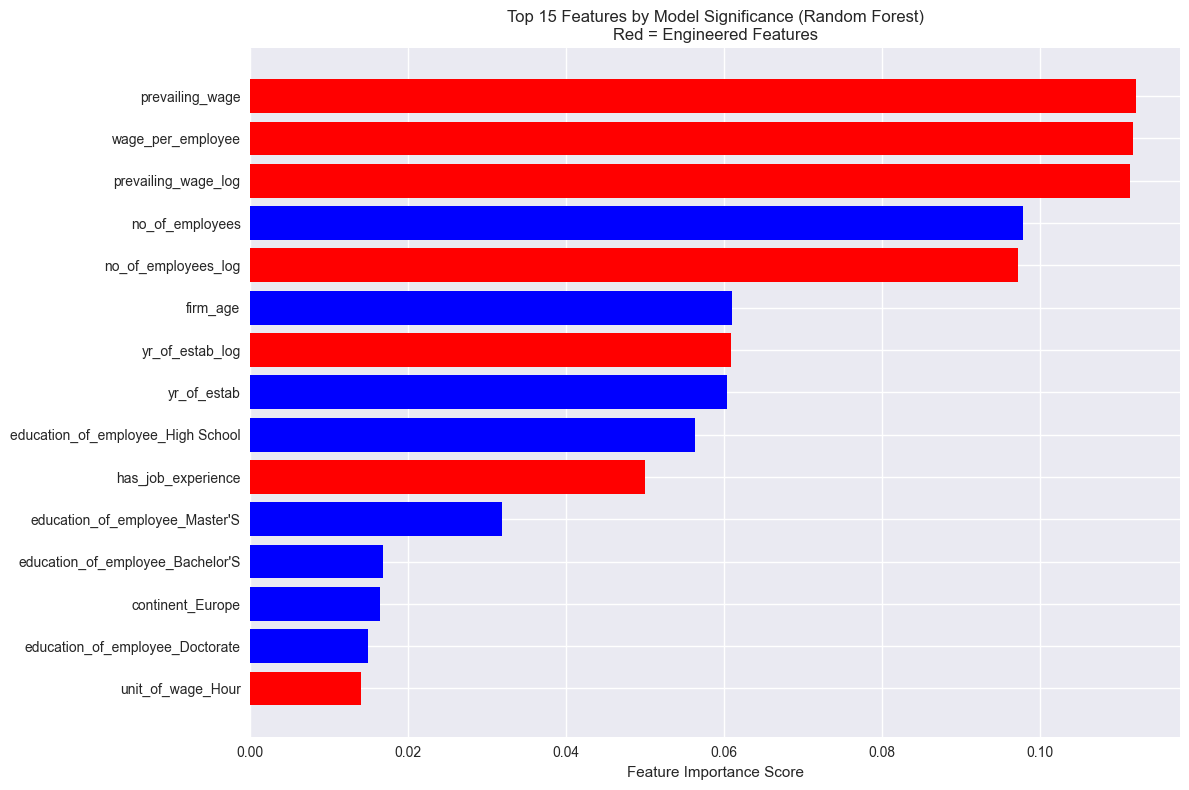


✓ Model-based feature importance analysis completed.
✓ 6 engineered features appeared in the top 10.



In [38]:
feature_importance_df, engineered_features = analyze_feature_importance_significance(X_train_scaled, y_train)


### 11. Save Preprocessed Data

In [39]:
import pandas as pd
import joblib
import json

def save_preprocessing_outputs(
    df_original,
    df_processed,
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    scaler,
    selected_features,
    engineered_features,
    feature_importance_df,
    log_transformed=None,
    outlier_treatment='IQR_capping',
    scaling_method='StandardScaler'
):
    """
    SAVE PREPROCESSED DATASETS AND METADATA
    =======================================
    Purpose:
        - Save all preprocessed data, target variables, scaling model, and feature importance summary.
        - Provides reproducibility and transparency for downstream modeling.

    Parameters:
        df_original (pd.DataFrame): Original dataset before preprocessing.
        df_processed (pd.DataFrame): Final processed dataset after preprocessing.
        X_train_scaled, X_val_scaled, X_test_scaled (pd.DataFrame): Scaled feature sets.
        y_train, y_val, y_test (pd.Series): Target variables.
        scaler: Fitted StandardScaler (or other scaling object).
        selected_features (list): List of features retained after selection.
        engineered_features (list): List of engineered feature names.
        feature_importance_df (pd.DataFrame): DataFrame containing feature importance info.
        log_transformed (list, optional): List of features log-transformed.
        outlier_treatment (str, optional): Outlier handling method used.
        scaling_method (str, optional): Scaling technique applied.
    """

    print("=== SAVING CASE STATUS PREPROCESSING OUTPUTS ===")

    # 1 Save scaled datasets
    X_train_scaled.to_csv('X_train_scaled.csv', index=False)
    X_val_scaled.to_csv('X_val_scaled.csv', index=False)
    X_test_scaled.to_csv('X_test_scaled.csv', index=False)

    # 2 Save target variables
    y_train.to_csv('y_train.csv', index=False)
    y_val.to_csv('y_val.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)

    # 3 Save preprocessing objects
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(selected_features, 'selected_features.pkl')

    # 4 Save feature importance
    feature_importance_df.to_csv('feature_importance.csv', index=False)

    # 5 Save preprocessing summary
    preprocessing_summary = {
        'original_shape': df_original.shape,
        'final_shape': df_processed.shape,
        'selected_features': selected_features,
        'engineered_features': engineered_features,
        'train_samples': X_train_scaled.shape[0],
        'val_samples': X_val_scaled.shape[0],
        'test_samples': X_test_scaled.shape[0],
        'scaling_method': scaling_method,
        'outlier_treatment': outlier_treatment,
        'log_transformed': log_transformed if log_transformed else []
    }

    with open('preprocessing_summary.json', 'w') as f:
        json.dump(preprocessing_summary, f, indent=2)

    print("✓ Preprocessed data saved successfully!\n")
    print("Created files:")
    print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
    print("- y_train.csv, y_val.csv, y_test.csv")
    print("- scaler.pkl, selected_features.pkl")
    print("- feature_importance.csv, preprocessing_summary.json")
    print("\nAll preprocessing artifacts saved and ready for modeling.\n")


In [42]:
save_preprocessing_outputs(
    df_original=df,                      # before preprocessing
    df_processed=df_processed,           # after preprocessing
    X_train_scaled=X_train_scaled,
    X_val_scaled=X_val_scaled,
    X_test_scaled=X_test_scaled,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    scaler=scaler,
    selected_features=df_selected.columns.drop('case_status').tolist(),
    #selected_features=df_selected,
    engineered_features=engineered_features,
    feature_importance_df=feature_importance_df,
    log_transformed=['no_of_employees_log', 'yr_of_estab_log', 'prevailing_wage_log'],
    outlier_treatment='IQR_capping',
    scaling_method='StandardScaler'
)


=== SAVING CASE STATUS PREPROCESSING OUTPUTS ===
✓ Preprocessed data saved successfully!

Created files:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json

All preprocessing artifacts saved and ready for modeling.

